# Brain Tumor Classification

In [50]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import os

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import utils

In [51]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

### Color palette

In [52]:
cmap = sns.color_palette("Blues")
cmap

[(0.8584083044982699, 0.9134486735870818, 0.9645674740484429),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944)]

### Properties

In [53]:
batch_size = 32
img_height = 180
img_width = 180

### Directory paths

In [54]:
train_dir = "./images/Training/"
test_dir = "./images/Testing/"

In [55]:
# Create a function to customize autopct parameter of plt.pie()
def make_autopct(values):
    
    def my_autopct(pct):
        # The pct is percentage value that matplotlib supplies for every wedge
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.2f}%  ({val})'
    
    return my_autopct

## Data Preprocessing

### Read Training Data

In [56]:
# Create Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [57]:
# Create Validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [58]:
# Get labels inferred by the method itself
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


## Data Visualization

### Visualize Train Data

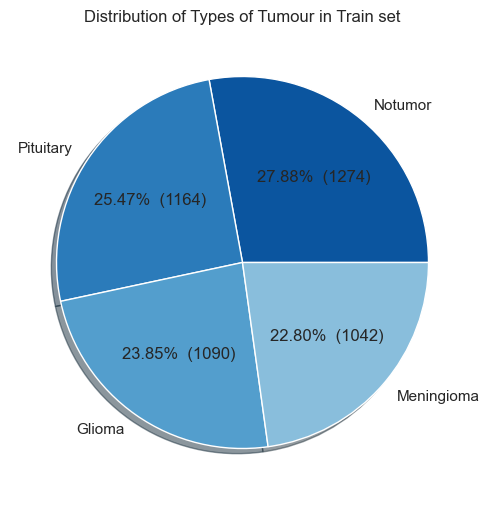

In [59]:
# Count instances in each class of train dataset
train_ds_labels = []

for _, labels in train_ds:
    for i in range(len(labels)):
        train_ds_labels.append(class_names[labels[i].numpy()])

# Create a pandas Dataset and apply a few methods
df = pd.DataFrame({'Category': train_ds_labels})
cat = df['Category'].value_counts().index.tolist()
cat = [i.title() for i in cat]
count = df['Category'].value_counts().tolist()

# Plot distribution of instances in our training data
sns.set(style="whitegrid")
plt.figure(figsize=(6, 8))
plt.pie(count, labels=cat, shadow=True,
        autopct=make_autopct(count), colors=cmap[::-1])
plt.title("Distribution of Types of Tumour in Train set")
plt.show()

### Visualize Validation Data

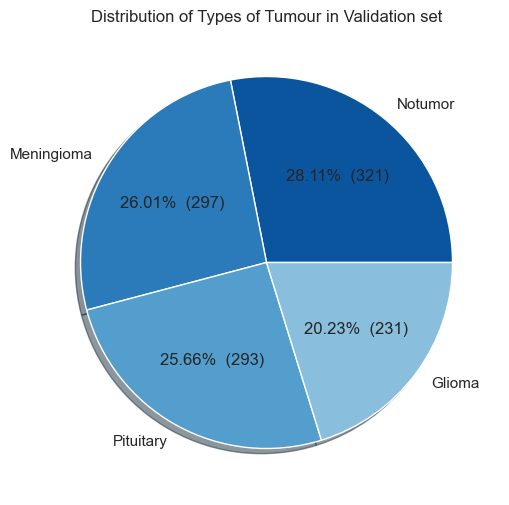

In [60]:
# Count instances in each class of validation set
val_ds_labels = []

for _, labels in val_ds:
    for i in range(len(labels)):
        val_ds_labels.append(class_names[labels[i].numpy()])

# Create a pandas Dataset and apply a few methods
df = pd.DataFrame({'Category': val_ds_labels})
cat = df['Category'].value_counts().index.tolist()
cat = [i.title() for i in cat]
count = df['Category'].value_counts().tolist()

# Plot distribution of instances in our validation data
sns.set(style="whitegrid")
plt.figure(figsize=(6, 8))
plt.pie(count, labels=cat, shadow=True,
        autopct=make_autopct(count), colors=cmap[::-1])
plt.title("Distribution of Types of Tumour in Validation set")
plt.show()

In [61]:
def plot_images(n_rows, n_cols, data_set):
    """
    Plots a figure containing all images in paths_img
    along with paths_label

    Parameters:
    n_rows: number of rows to plot in figure
    n_cols: number of cols to plot in figure
    data_set: The dataset of images to plot
            data_set type: tf.data.Dataset
    """
    plt.figure(figsize=(n_cols*2.25, n_rows*2.25))
    for images, labels in train_ds.take(1):
        for i in range(n_rows*n_cols):
            ax = plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.axis('off')
            plt.title(class_names[labels[i]], fontsize=12, pad=8)
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    plt.show()

### Viewing few images of the dataset

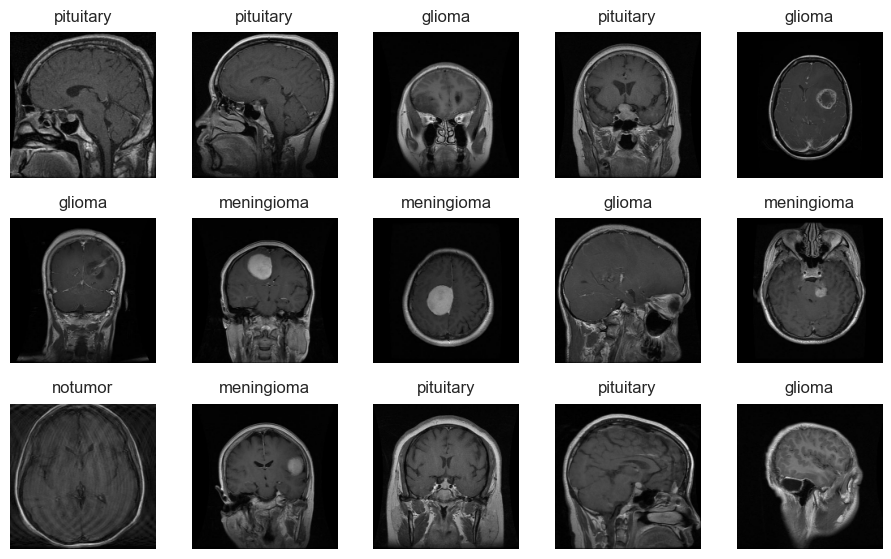

In [62]:
plot_images(3, 5, train_ds)

## Standardize the data and Data Augmentation
### Benefit:
When we export our model using model.save, the preprocessing layers will be saved along with the rest of our model. If we later deploy this model, it will automatically standardize images (according to the configuration of our layers). This can save us from the effort of having to reimplement that logic server-side.

### Scaling pixels from range 0 to 1

In [63]:
normalization_layer = layers.Rescaling(1./255)

In [64]:
# Apply some techniques like flip, rotate and zoom
# inorder to increase the quality and amount of data
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [65]:
def plot_images_augmented(dataset):
    """
    Parameters:
    : dataset - dataset of type `tf.data.Dataset` 
                with images to plot
    """
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

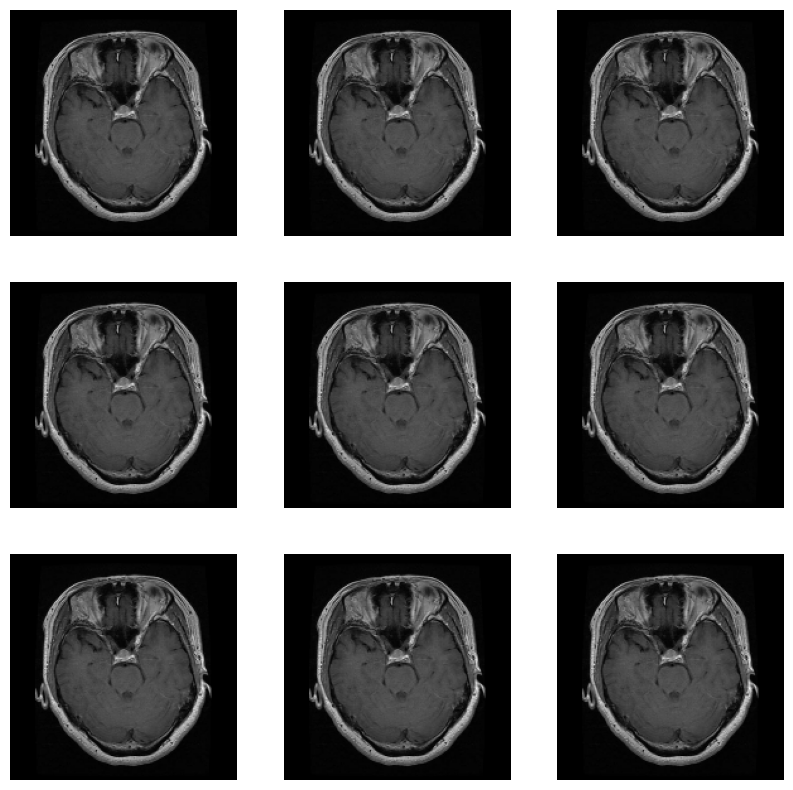

In [66]:
plot_images_augmented(train_ds)

## Training Model

In [67]:
# Number of classes in dataset (for output layer)
num_classes = len(class_names)

# Create Model
model = keras.Sequential([
  data_augmentation,
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [68]:
# Compile the above model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [69]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Callbacks
1. `ModelCheckpoint`: it will save checkpoints of our model at the end of each epoch and save model whose performance on validation set is best so far (if save_best_model parameter is set True)
2. `EarlyStopping`: interrupts training when no progress on validation set is made after several epochs (set by patience parameter) and loads back to best model (optionally)

In [70]:
# Model Checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/kaggle/working/modelCheckpoint/brainT_detect.h5"
)
# Early Stopping
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

In [71]:
# Fit model with our train data and cal-c validation 
# score at each epoch
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
        checkpoint_cb,
        early_stopping_cb
    ]
)

Epoch 1/10
143/143 [==============================] - 46s 297ms/step - loss: 0.8632 - accuracy: 0.6418 - val_loss: 0.6947 - val_accuracy: 0.7391
Epoch 2/10
143/143 [==============================] - 41s 287ms/step - loss: 0.5494 - accuracy: 0.7888 - val_loss: 0.5925 - val_accuracy: 0.7855
Epoch 3/10
143/143 [==============================] - 41s 289ms/step - loss: 0.4875 - accuracy: 0.8133 - val_loss: 0.7456 - val_accuracy: 0.7408
Epoch 4/10
143/143 [==============================] - 41s 287ms/step - loss: 0.4163 - accuracy: 0.8451 - val_loss: 0.4139 - val_accuracy: 0.8424
Epoch 5/10
143/143 [==============================] - 41s 286ms/step - loss: 0.3880 - accuracy: 0.8505 - val_loss: 0.4532 - val_accuracy: 0.8424
Epoch 6/10
143/143 [==============================] - 41s 289ms/step - loss: 0.3330 - accuracy: 0.8744 - val_loss: 0.5870 - val_accuracy: 0.7890
Epoch 7/10
143/143 [==============================] - 41s 285ms/step - loss: 0.3015 - accuracy: 0.8860 - val_loss: 0.4547 - val_ac

### Model is saved again! (at different path)

In [74]:
import time
model.save(f"brainT_detect{time.time()}.h5")

### Plotting the training curves (train & validation accuracy & loss)

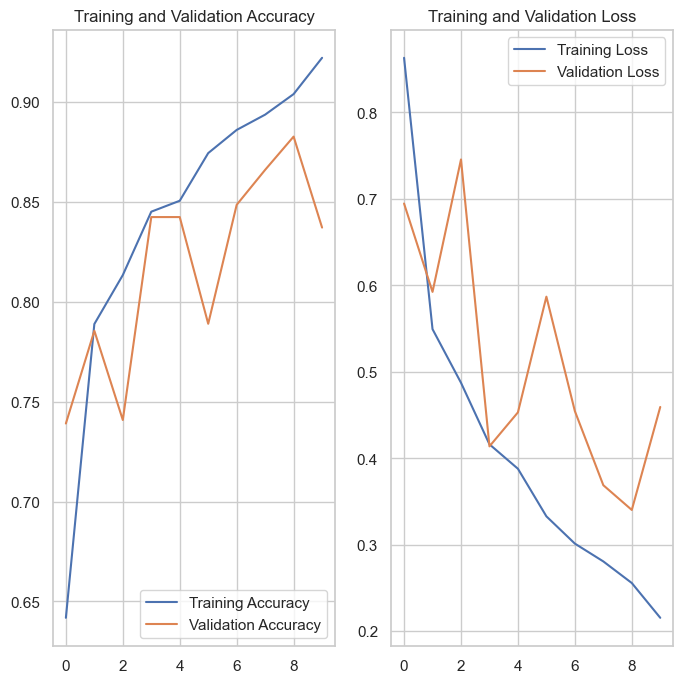

In [75]:
epochs = len(history.epoch)  # epochs completed by early stopping
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluating Model

### Preparing Test Data

In [76]:
# Read test set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

Found 1311 files belonging to 4 classes.


In [77]:
# Make predictions on test set
predictions = model.predict(test_ds)
# We use tf.nn.softmax as we applied padding in training & task is of multiclass
# prediction. Threfore, we used `SparseCategoricalCrossentropy` in model.compile()
scores = tf.nn.softmax(predictions[:])

41/41 [==============================] - 1s 24ms/step


In [78]:
for i in range(10):
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(scores[i])], 100 * np.max(scores[i]))
    )

This image most likely belongs to meningioma with a 93.52 percent confidence.
This image most likely belongs to glioma with a 94.19 percent confidence.
This image most likely belongs to notumor with a 98.16 percent confidence.
This image most likely belongs to pituitary with a 98.80 percent confidence.
This image most likely belongs to meningioma with a 85.85 percent confidence.
This image most likely belongs to pituitary with a 100.00 percent confidence.
This image most likely belongs to notumor with a 100.00 percent confidence.
This image most likely belongs to pituitary with a 99.90 percent confidence.
This image most likely belongs to pituitary with a 99.58 percent confidence.
This image most likely belongs to notumor with a 70.83 percent confidence.


## Loading the saved model

In [79]:
loaded_model = keras.models.load_model("./brainT_detect1682946468.3700671.h5")

In [80]:
# Make predictions on test set
predictions = loaded_model.predict(test_ds)
# We use tf.nn.softmax as we applied padding in training & task is of multiclass
# prediction. Threfore, we used `SparseCategoricalCrossentropy` in model.compile()
scores = tf.nn.softmax(predictions[:])

41/41 [==============================] - 1s 22ms/step


In [81]:
for i in range(10):
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(scores[i])], 100 * np.max(scores[i]))
    )

This image most likely belongs to notumor with a 76.82 percent confidence.
This image most likely belongs to notumor with a 99.99 percent confidence.
This image most likely belongs to meningioma with a 85.45 percent confidence.
This image most likely belongs to pituitary with a 97.17 percent confidence.
This image most likely belongs to meningioma with a 96.23 percent confidence.
This image most likely belongs to meningioma with a 93.52 percent confidence.
This image most likely belongs to notumor with a 100.00 percent confidence.
This image most likely belongs to glioma with a 90.20 percent confidence.
This image most likely belongs to meningioma with a 99.05 percent confidence.
This image most likely belongs to pituitary with a 88.89 percent confidence.
